# モデルの学習

In [61]:
# import libraries

import numpy as np
import pandas as pd
import gc
import os
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import plotly.express as px
import re
import datetime as dt
import japanize_matplotlib
import itertools
year_pattern = r'([1-2][0-9]{3})'
import time

In [62]:
DATAPATH = "../../../data/DBLP/made/"
OUTPUTPATH = "../../../result/aminer/"

In [63]:
with open(DATAPATH + "keywords_delete_similar_words.txt") as f:
    keywords = list(map(lambda x: x.replace("\n", ""), f.readlines()))
key_sets = set(keywords)
len(keywords), keywords[0]

(2275, '3d imaging')

In [64]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import utils

from scipy.stats import pearsonr

In [65]:
train_x = np.load(DATAPATH + "train_x.npy")
train_y = np.load(DATAPATH + "train_y.npy")

test_x = np.load(DATAPATH + "test_x.npy")
test_y = np.load(DATAPATH + "test_y.npy")
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2275, 2275, 23), (2275, 2275), (2275, 2275, 23), (2275, 2275))

In [66]:
N = train_x.shape[0]
M = train_x.shape[2]
N, M

(2275, 23)

In [67]:
train_x, train_y, test_x, test_y = train_x[np.triu_indices(n=N, k=1)], train_y[np.triu_indices(n=N, k=1)], test_x[np.triu_indices(n=N, k=1)], test_y[np.triu_indices(n=N, k=1)]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2586675, 23), (2586675,), (2586675, 23), (2586675,))

In [68]:
P = train_x.shape[0]
P

2586675

In [69]:
model = LinearRegression()
start_time = time.perf_counter()
model.fit(train_x, train_y)
print("フィッティング時間: {}".format(time.perf_counter() - start_time))
start_time = time.perf_counter()
model.score(test_x, test_y)
print("スコア時間: {}".format(time.perf_counter() - start_time))

フィッティング時間: 1.9469756372272968
スコア時間: 0.07257544994354248


In [70]:
result = model.predict(test_x)
result_before = model.predict(train_x)
result.shape, result_before.shape

((2586675,), (2586675,))

In [71]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result_before, train_y)),3), 
    round(mean_squared_error(result_before, train_y),3),
    round(pearsonr(result_before, train_y)[0],3)))

RMSE: 10.944, MSE: 119.771, 相関係数: 0.822


In [72]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result, test_y)),3), 
    round(mean_squared_error(result, test_y),3),
    round(pearsonr(result, test_y)[0],3)))

RMSE: 5.595, MSE: 31.303, 相関係数: 0.583


In [73]:
df = pd.DataFrame(result, columns=["予測"])
df["実測"] = test_y
df["予測順位"] = df["予測"].rank(ascending=False)
df["実測順位"] = df["実測"].rank(ascending=False)
df = df.sort_values("予測順位", )
top = df.head(100)
len(top[top["実測順位"]<100]) / len(top)

0.43

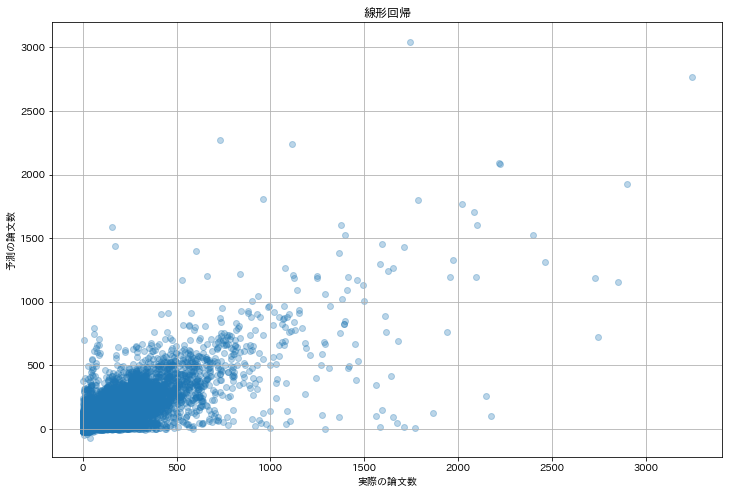

In [74]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(train_y, result_before, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("線形回帰")
fig.show()

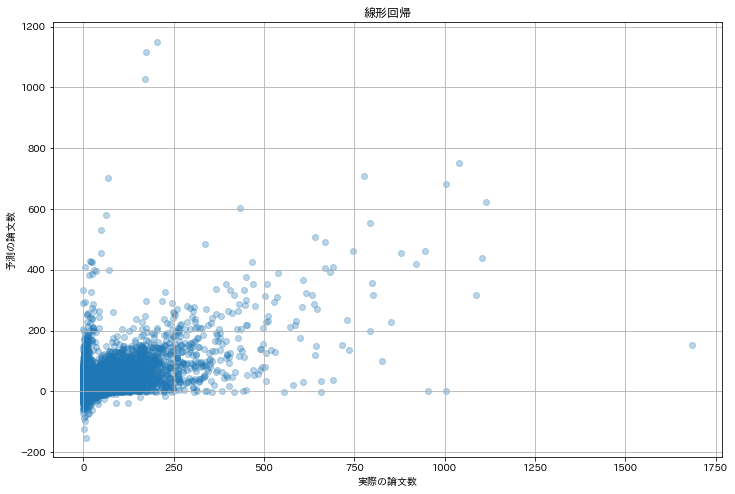

In [75]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(test_y, result, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("線形回帰")
fig.savefig(OUTPUTPATH+"img/lr.png")
fig.show()

In [76]:
predict_matrix = np.zeros([N,N]) 
correct_matrix = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
predict_matrix[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if predict_matrix[i][j] > 400:
            print("キーワード: {}, {}, 予測値: {}, 実測値: {}".format(keywords[i], keywords[j],round(predict_matrix[i][j],1), correct_matrix[i][j]))

キーワード: accuracy, feature extraction, 予測値: 425.9, 実測値: 24.0
キーワード: algorithm, design, 予測値: 1028.9, 実測値: 171.0
キーワード: algorithm, experimentation, 予測値: 702.5, 実測値: 68.0
キーワード: algorithm, performance, 予測値: 1148.8, 実測値: 203.0
キーワード: algorithm design and analysis, optimisation, 予測値: 426.5, 実測値: 466.0
キーワード: bioinformatics, biomedical research, 予測値: 408.4, 実測値: 6.0
キーワード: capacitors, switches, 予測値: 490.6, 実測値: 669.0
キーワード: computational model, data model, 予測値: 461.1, 実測値: 947.0
キーワード: computational model, mathematical models, 予測値: 683.7, 実測値: 1003.0
キーワード: decoding, encoding, 予測値: 404.9, 実測値: 670.0
キーワード: design, experimentation, 予測値: 530.3, 実測値: 48.0
キーワード: design, human factors, 予測値: 426.3, 実測値: 20.0
キーワード: design, performance, 予測値: 1116.3, 実測値: 173.0
キーワード: estimation, noise, 予測値: 428.2, 実測値: 18.0
キーワード: experimentation, performance, 予測値: 581.1, 実測値: 63.0
キーワード: feature extraction, support vector machine, 予測値: 463.3, 実測値: 746.0
キーワード: feature extraction, visualization, 予測値: 455.6, 実測値: 878

In [77]:
bool_matrix = np.zeros([N,N]) 
bool_matrix[np.triu_indices(n=N, k=1)] = train_y
word_matrix = np.zeros([N,N,2]).astype(str)
for i in range(N):
    for j in range(N):
        word_matrix[i][j][0] = keywords[i]
        word_matrix[i][j][1] = keywords[j]
correct_new = correct_matrix[np.where(bool_matrix==0)]
predict_new = predict_matrix[np.where(bool_matrix==0)]
word_new = word_matrix[np.where(bool_matrix==0)]

In [78]:
df = pd.DataFrame(correct_new, columns=["実測値"])
df["予測値"] = predict_new
df["キーワード1"] = word_new[:,0]
df["キーワード2"] = word_new[:,1]
df.head()

,実測値,予測値,キーワード1,キーワード2
0,0.0,0.000000,3d imaging,3d imaging
1,0.0,1.008812,3d imaging,a priori knowledge
2,0.0,3.437279,3d imaging,accelerometers
3,0.0,0.670922,3d imaging,access control
4,0.0,2.995314,3d imaging,access network


In [79]:
df.sort_values("予測値", ascending=False, inplace=True)
df.head(20)

,実測値,予測値,キーワード1,キーワード2
334415,0.0,8.807918,change management,health information systems
1452909,0.0,8.637984,health information systems,organisational aspects
620137,0.0,8.526610,creativity,health information systems
1452498,0.0,8.231180,health information systems,instructional design
1385214,0.0,7.936509,graph g,regular language
1452406,0.0,7.909186,health information systems,higher education
1044699,0.0,7.830931,enterprise architecture,instructional design
399197,0.0,7.803923,cochannel interference,multiaccess communication
619941,0.0,7.717166,creativity,enterprise architecture
286782,0.0,7.716261,business information systems,creativity


In [80]:
df.sort_values("実測値", ascending=False, inplace=True)
df.head(20)

,実測値,予測値,キーワード1,キーワード2
3703880,953.0,1.156474,task analysis,training
1740315,224.0,3.830746,internet of things,task analysis
744974,168.0,0.415477,deconvolution,task analysis
741952,154.0,0.516809,decoding,task analysis
459010,149.0,4.723251,complexity theory,mimo communication
2163214,144.0,3.147350,mobile handsets,task analysis
77476,115.0,0.317256,analytical models,task analysis
3035679,110.0,0.168432,remote sensing,task analysis
3538568,104.0,3.969452,standards,task analysis
459545,98.0,4.251003,complexity theory,task analysis


In [81]:
model.coef_

array([ 5.91519730e+00,  5.78265807e+00,  1.73606008e+00,  4.23719095e-01,
        2.28588489e+01,  4.51066249e-01, -1.24502754e+01, -7.91335368e-01,
        4.51066249e-01, -1.24502754e+01, -7.91335368e-01,  4.51066249e-01,
       -1.24502754e+01, -7.91335368e-01,  1.38621408e+01,  1.27239559e+00,
        3.66835234e+01, -3.85195829e+01,  8.72248545e-02, -2.41789266e-01,
       -4.75335745e-01,  3.37385238e-02,  3.35626750e+00])

# 人気度

In [43]:
train_x = np.load(DATAPATH + "train_x.npy")
train_y = np.load(DATAPATH + "train_y_diff.npy")

test_x = np.load(DATAPATH + "test_x.npy")
test_y = np.load(DATAPATH + "test_y_diff.npy")
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2275, 2275, 23), (2275, 2275), (2275, 2275, 23), (2275, 2275))

In [44]:
train_x, train_y, test_x, test_y = train_x[np.triu_indices(n=N, k=1)], train_y[np.triu_indices(n=N, k=1)], test_x[np.triu_indices(n=N, k=1)], test_y[np.triu_indices(n=N, k=1)]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2586675, 23), (2586675,), (2586675, 23), (2586675,))

In [45]:
model = LinearRegression()
start_time = time.perf_counter()
model.fit(train_x, train_y)
print("フィッティング時間: {}".format(time.perf_counter() - start_time))
start_time = time.perf_counter()
model.score(test_x, test_y)
print("スコア時間: {}".format(time.perf_counter() - start_time))
result = model.predict(test_x)
result_before = model.predict(train_x)

フィッティング時間: 2.090621951967478
スコア時間: 0.07304241508245468


In [46]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result_before, train_y)),3), 
    round(mean_squared_error(result_before, train_y),3),
    round(pearsonr(result_before, train_y)[0],3)))

RMSE: 10.944, MSE: 119.771, 相関係数: 0.751


In [47]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result, test_y)),3), 
    round(mean_squared_error(result, test_y),3),
    round(pearsonr(result, test_y)[0],3)))

RMSE: 5.595, MSE: 31.303, 相関係数: 0.951


In [48]:
df = pd.DataFrame(result, columns=["予測"])
df["実測"] = test_y
df["予測順位"] = df["予測"].rank(ascending=True)
df["実測順位"] = df["実測"].rank(ascending=True)
df = df.sort_values("予測順位", )
top = df.head(100)
len(top[top["実測順位"]<100]) / len(top)

0.83

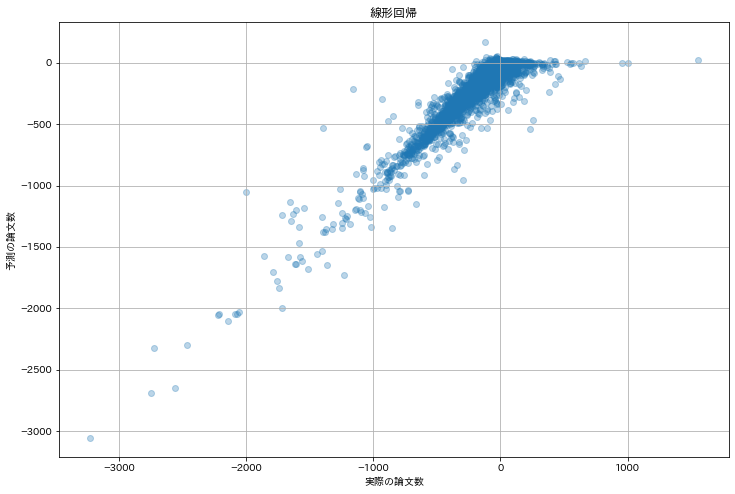

In [49]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(test_y, result, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("線形回帰")
fig.savefig(OUTPUTPATH+"img/lr_diff.png")
fig.show()

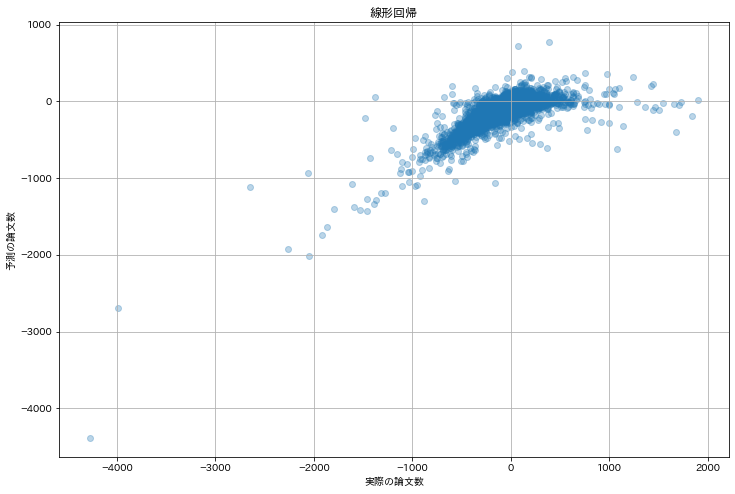

In [50]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(train_y, result_before, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("線形回帰")
# fig.savefig(OUTPUTPATH+"img/gbm.png")
fig.show()

In [53]:
predict_matrix = np.zeros([N,N]) 
correct_matrix = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
predict_matrix[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if predict_matrix[i][j] < -2000:
            print("キーワード: {}, {}, 予測値: {}, 実測値: {}".format(keywords[i], keywords[j],round(predict_matrix[i][j],1), correct_matrix[i][j]))

キーワード: algorithm, bioinformatics, 予測値: -3052.5, 実測値: -3231.0
キーワード: algorithm, microarrays, 予測値: -2054.5, 実測値: -2223.0
キーワード: algorithm design, algorithm design and analysis, 予測値: -2102.2, 実測値: -2145.0
キーワード: bioinformatics, biomedical research, 予測値: -2320.6, 実測値: -2723.0
キーワード: bioinformatics, microarrays, 予測値: -2043.0, 実測値: -2217.0
キーワード: computational model, computer model, 予測値: -2688.4, 実測値: -2747.0
キーワード: feature extraction, image classification, 予測値: -2646.3, 実測値: -2556.0
キーワード: feature extraction, support vector machine, 予測値: -2000.7, 実測値: -1718.0
キーワード: field programmable gate array, fpga, 予測値: -2049.7, 実測値: -2088.0
キーワード: learning (artificial intelligence, machine learning, 予測値: -2033.8, 実測値: -2054.0
キーワード: mobile communications, mobile computing, 予測値: -2295.1, 実測値: -2464.0
キーワード: qos, quality of service, 予測値: -2048.8, 実測値: -2074.0


In [54]:
correct_new = correct_matrix[np.where(bool_matrix==0)]
predict_new = predict_matrix[np.where(bool_matrix==0)]
word_new = word_matrix[np.where(bool_matrix==0)]

In [55]:
df = pd.DataFrame(correct_new, columns=["実測値"])
df["予測値"] = predict_new
df["キーワード1"] = word_new[:,0]
df["キーワード2"] = word_new[:,1]
df.head()

,実測値,予測値,キーワード1,キーワード2
0,0.0,0.000000,3d imaging,3d imaging
1,0.0,1.008812,3d imaging,a priori knowledge
2,0.0,3.437279,3d imaging,accelerometers
3,0.0,0.670922,3d imaging,access control
4,0.0,2.995314,3d imaging,access network


In [57]:
df.sort_values("予測値", ascending=False, inplace=True)
df.head(20)

,実測値,予測値,キーワード1,キーワード2
334415,0.0,8.807918,change management,health information systems
1452909,0.0,8.637984,health information systems,organisational aspects
620137,0.0,8.526610,creativity,health information systems
1452498,0.0,8.231180,health information systems,instructional design
1385214,0.0,7.936509,graph g,regular language
1452406,0.0,7.909186,health information systems,higher education
1044699,0.0,7.830931,enterprise architecture,instructional design
399197,0.0,7.803923,cochannel interference,multiaccess communication
619941,0.0,7.717166,creativity,enterprise architecture
286782,0.0,7.716261,business information systems,creativity


In [58]:
df.sort_values("実測値", ascending=False, inplace=True)
df.head(20)

,実測値,予測値,キーワード1,キーワード2
3703880,953.0,1.156474,task analysis,training
1740315,224.0,3.830746,internet of things,task analysis
744974,168.0,0.415477,deconvolution,task analysis
741952,154.0,0.516809,decoding,task analysis
459010,149.0,4.723251,complexity theory,mimo communication
2163214,144.0,3.147350,mobile handsets,task analysis
77476,115.0,0.317256,analytical models,task analysis
3035679,110.0,0.168432,remote sensing,task analysis
3538568,104.0,3.969452,standards,task analysis
459545,98.0,4.251003,complexity theory,task analysis


In [60]:
len(df)

4211183